In [40]:
import pandas as pd
import altair as alt
import datetime as dt

In [59]:
df = pd.read_csv('../data/supermarket_sales.csv',
                 parse_dates = {'Date_time': ['Date', 'Time']})
df.head()

,Date_time,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Payment,cogs,gross margin percentage,gross income,Rating
0,2019-01-05 13:08:00,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,Ewallet,522.83,4.761905,26.1415,9.1
1,2019-03-08 10:29:00,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,Cash,76.40,4.761905,3.8200,9.6
2,2019-03-03 13:23:00,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,Credit card,324.31,4.761905,16.2155,7.4
3,2019-01-27 20:33:00,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,Ewallet,465.76,4.761905,23.2880,8.4
4,2019-02-08 10:37:00,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,Ewallet,604.17,4.761905,30.2085,5.3


In [60]:
# add day of the week
df['Day_of_week'] = df['Date_time'].dt.weekday_name
# add time of day

In [224]:
morning = df.set_index('Date_time').between_time('10:00', '11:59')
morning['Time_of_day'] = 'Morning'
morning
afternoon = df.set_index('Date_time').between_time('12:00', '17:59')
afternoon['Time_of_day'] = 'Afternoon'
evening = df.set_index('Date_time').between_time('18:00', '20:59')
evening['Time_of_day'] = 'Evening'

new_df = pd.concat([morning, afternoon, evening])

def total_by_hour(row):
    if row['Time_of_day'] == 'Morning':
        val = row['Total'] / 2
    elif row['Time_of_day'] == 'Afternoon':
        val = row['Total'] / 6
    elif row['Time_of_day'] == 'Evening':
        val = row['Total'] / 3
    return val

new_df['Total_per_hour'] = new_df.apply(total_by_hour, axis=1)

# Wrangle data for transaction count per hour
df_2 = new_df.groupby(['Day_of_week', 'Time_of_day']).agg({'Invoice ID': 'count'})

def count_by_hour(row):
    if row['Time_of_day'] == 'Morning':
        val = row['Invoice ID'] / 2
    elif row['Time_of_day'] == 'Afternoon':
        val = row['Invoice ID'] / 6
    elif row['Time_of_day'] == 'Evening':
        val = row['Invoice ID'] / 3
    return val

df_2 = df_2.reset_index()
df_2['Count_per_hour'] = df_2.apply(count_by_hour, axis=1)
df_2.head()

,Day_of_week,Time_of_day,Invoice ID,Count_per_hour
0,Friday,Afternoon,74,12.333333
1,Friday,Evening,36,12.000000
2,Friday,Morning,29,14.500000
3,Monday,Afternoon,75,12.500000
4,Monday,Evening,29,9.666667


In [225]:
# Wrange data for average spend per hour (average transaction size = total/transaction count)
df_3 = new_df.groupby(['Day_of_week', 'Time_of_day']).agg({'Total': 'sum'})
df_3 = df_3.reset_index() # You could just plot this instead of creating `new_df`
df_3['Total_per_hour'] = df_3.apply(total_by_hour, axis=1)
df_3['Count_per_hour'] = df_2['Count_per_hour']
df_3['Avg_spend_per_hour'] = df_3['Total_per_hour'] / df_3['Count_per_hour']
df_3.head()

,Day_of_week,Time_of_day,Total,Total_per_hour,Count_per_hour,Avg_spend_per_hour
0,Friday,Afternoon,22831.6410,3805.2735,12.333333,308.535689
1,Friday,Evening,12773.7225,4257.9075,12.000000,354.825625
2,Friday,Morning,8320.9770,4160.4885,14.500000,286.930241
3,Monday,Afternoon,23500.6800,3916.7800,12.500000,313.342400
4,Monday,Evening,7787.3460,2595.7820,9.666667,268.529172


In [228]:
# Wrangle data for customer satisfaction

In [289]:
# Total transaction per hour
plot_1 = (alt
 .Chart(new_df)
 .mark_rect()
 .encode(
     alt.X('Day_of_week:N', title=None, sort=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']),
     alt.Y('Time_of_day:N', title=None, sort=['Morning', 'Afternoon', 'Evening']),
     alt.Color('sum(Total_per_hour):Q', title=None),
     tooltip='sum(Total_per_hour):Q')
 .configure_axis(labelFontSize=14, titleFontSize=14)
 .configure_title(fontSize=16)
 .properties(width=200, height=150, title='Total per hour')
)

# Transaction count

plot_2 = (alt
 .Chart(df_2)
 .mark_rect()
 .encode(
     alt.X('Day_of_week:N', title=None, sort=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']),
     alt.Y('Time_of_day:N', title=None, sort=['Morning', 'Afternoon', 'Evening']),
     alt.Color('Count_per_hour:Q', title=None),
     tooltip='Count_per_hour:Q')
 .configure_axis(labelFontSize=14, titleFontSize=14)
 .configure_title(fontSize=16)
 .properties(width=200, height=150, title='Transaction count per hour')
)

# Average transaction size per hour
plot_3 = (alt
 .Chart(df_3)
 .mark_rect()
 .encode(
     alt.X('Day_of_week:N', title=None, sort=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']),
     alt.Y('Time_of_day:N', title=None, sort=['Morning', 'Afternoon', 'Evening']),
     alt.Color('Avg_spend_per_hour:Q', title=None),
     tooltip='Avg_spend_per_hour:Q')
 .configure_axis(labelFontSize=14, titleFontSize=14)
 .configure_title(fontSize=16)
 .properties(width=200, height=150, title='Avg transaction size per hour')
)

# Average customer satisfaction
plot_4 = (alt
 .Chart(new_df)
 .mark_rect()
 .encode(
     alt.X('Day_of_week:N', title=None, sort=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']),
     alt.Y('Time_of_day:N', title=None, sort=['Morning', 'Afternoon', 'Evening']),
     alt.Color('mean(Rating):Q', title=None),
     tooltip='mean(Rating)):Q')
 .configure_axis(labelFontSize=14, titleFontSize=14)
 .configure_title(fontSize=16)
 .properties(width=200, height=150, title='Avg customer satisfaction')
)

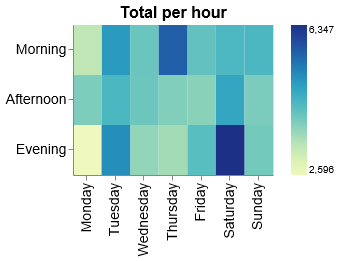

In [290]:
plot_1

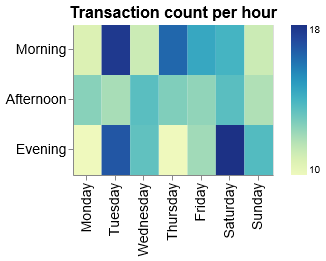

In [291]:
plot_2

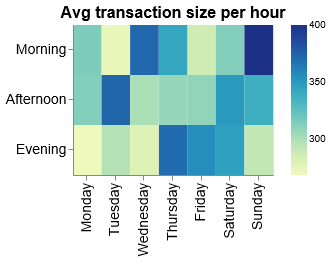

In [292]:
plot_3

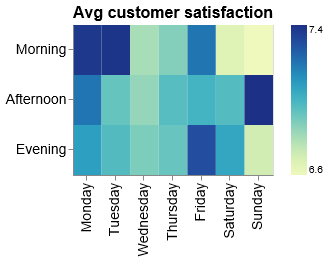

In [288]:
plot_4